In [1]:
# import modules
import pandas as pd
import numpy as np
import torch
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
datadir = "/Users/yihyun/Code"

2023-05-12 09:14:25.191006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:14:26.546494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546576: W 

In [2]:
# evaluation functions
def masked_aCC(pred, label, mask):
    # multi-output average correlation coefficient with masking
    d_label = (label - np.nansum(label,1)/np.sum(mask, 1))
    d_pred = (pred - np.nansum(pred,1)/np.sum(mask, 1))
    x = np.nansum(np.multiply(d_label,d_pred), 1)
    y = np.sqrt(np.multiply(np.nansum(np.square(d_label), 1) , np.nansum(np.square(d_pred), 1)))
    #aCC = np.mean(x/y)
    return x/y
def masked_mse(pred, label, mask):
    # multi-output mse with masking
    return np.nansum(np.array(pred-label)**2, 1)/np.sum(np.array(mask),1)

def one_hot(vector, n):
    out = np.zeros(n)
    for i in vector:
        out[i] = 1
    return out

In [ ]:
# 3-1. compare with Precily
CCLE_info = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/CCLE_sample_info.csv"), index_col = 1)
Precily_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/3.Model_comparison/prediction/Precily_prediction.csv"), index_col = 0)
Precily_pred_wide = pd.pivot(Precily_pred, index = "drug_name", columns="cell_line", values="prediction")
Precily_label_wide = pd.pivot(Precily_pred, index = "drug_name", columns="cell_line", values="label")
cl_GDSC = CCLE_info.loc[list(set(Precily_pred['cell_line']))]["DepMap_ID"].values

pred_Precily = np.matrix(Precily_pred_wide)
label_Precily = np.matrix(Precily_label_wide)
mask_Precily = np.matrix(np.isnan(Precily_label_wide)==False, dtype=int)

GDSC_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_external_pred.csv"), index_col=0)
GDSC_pred = GDSC_pred[cl_GDSC]
GDSC = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/GDSC2_external_IC50.csv"), index_col=0)
GDSC = GDSC[GDSC_pred.columns]
GDSC_all = np.array(GDSC)[np.array(GDSC.isna()==False)]
GDSC_pred_all = np.array(GDSC_pred)[np.array(GDSC.isna()==False)]

pred_GDSC = np.matrix(GDSC_pred)
label_GDSC = np.matrix(GDSC)
mask_GDSC = np.matrix(np.isnan(GDSC)==False, dtype=int)

In [31]:
# cell-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for cell_line in GDSC_pred.columns:
    tmp_data = GDSC.loc[GDSC_pred.index, cell_line].dropna()
    tmp_result = GDSC_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
Precily_scc_result = []
for cell_line in Precily_pred_wide.columns:
    tmp_data = Precily_label_wide.loc[Precily_pred_wide.index, cell_line].dropna()
    tmp_result = Precily_pred_wide.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    Precily_scc_result.append(scc)


0.3881006864988559
0.10922631362030864


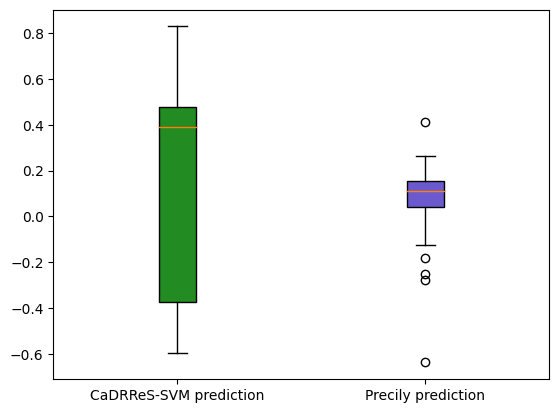

In [32]:
# cell-wise SCC Boxplot
print(np.median(np.array(GDSC_scc_result)))
print(np.median(np.array(Precily_scc_result)))

colors_dict={"CaDRReS-SVM prediction": "forestgreen", "Precily prediction": "slateblue"}

pred_dict = {'CaDRReS-SVM prediction': np.array(GDSC_scc_result),
            'Precily prediction': np.array(Precily_scc_result),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [33]:
# drug-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for smiles in GDSC_pred.index:
    tmp_data = GDSC.loc[smiles, GDSC_pred.columns].dropna()
    tmp_result = GDSC_pred.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
Precily_scc_result = []
for smiles in Precily_pred_wide.index:
    tmp_data = Precily_label_wide.loc[smiles, Precily_pred_wide.columns].dropna()
    tmp_result = Precily_pred_wide.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    Precily_scc_result.append(scc)
#PRISM_scc_result = [scc for scc in PRISM_scc_result if np.isnan(scc)==False]

0.5640287583909959
0.4947876474767032


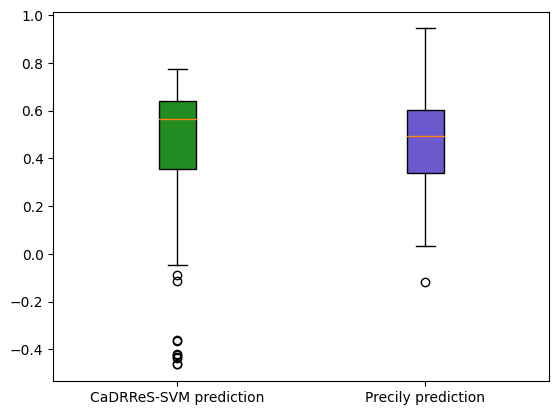

In [34]:
# drug-wise SCC Boxplot
print(np.median(np.array(GDSC_scc_result)))
print(np.median(np.array(Precily_scc_result)))

colors_dict={"CaDRReS-SVM prediction": "forestgreen", "Precily prediction": "slateblue"}

pred_dict = {'CaDRReS-SVM prediction': np.array(GDSC_scc_result),
            'Precily prediction': np.array(Precily_scc_result),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [26]:
# 3-2. check how many drugs in GDSC external testing are also in the Precily training set
import rdkit
from rdkit import Chem
with open(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/GDSC_smiles.pickle"), 'rb') as f:
    smiles_dict = pickle.load(f)
drugid_dict = {Chem.MolToSmiles(Chem.MolFromSmiles(v)):k for k,v in smiles_dict.items()}
drug_id = [drugid_dict[mol] for mol in GDSC_pred.index]
GDSC_compound =  pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/raw/screened_compounds_rel_8.4.csv"), index_col="DRUG_ID")
Drug_name = GDSC_compound.loc[list(set(drug_id)-set([1807, 1818]))]["DRUG_NAME"].to_list()
Drug_name += ['VINCRISTINE', 'CARMUSTINE']
#[1807, 1818]
#['VINCRISTINE', 'CARMUSTINE']
Precily_train = pd.read_csv(os.path.join(datadir, "/repo/Precily/Data/Complete_Training_data_for_DNN.csv"), index_col=0)
len(set(Precily_train["dt.merged$DRUG_NAME"]) & set(Drug_name))
# [1635, 1925, 1855, 1807, 1818]
unknown_drug = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles_dict[id])) for id in [1635, 1925, 1855, 1807, 1818]]

0.5968550415770092
0.6762916670956494


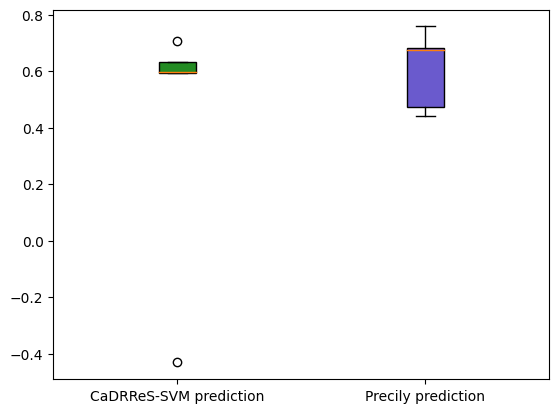

In [28]:
# drug-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for smiles in unknown_drug:
    tmp_data = GDSC.loc[smiles, GDSC_pred.columns].dropna()
    tmp_result = GDSC_pred.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
Precily_scc_result = []
for smiles in unknown_drug:
    tmp_data = Precily_label_wide.loc[smiles, Precily_pred_wide.columns].dropna()
    tmp_result = Precily_pred_wide.loc[smiles, tmp_data.index]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    Precily_scc_result.append(scc)

# drug-wise SCC
print(np.median(np.array(GDSC_scc_result)))
print(np.median(np.array(Precily_scc_result)))

colors_dict={"CaDRReS-SVM prediction": "forestgreen", "Precily prediction": "slateblue"}

pred_dict = {'CaDRReS-SVM prediction': np.array(GDSC_scc_result),
            'Precily prediction': np.array(Precily_scc_result),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()